# 🛍️ Mall Customer Segmentation with K-Means

Bu proje, alışveriş merkezi müşterilerini gelir ve harcama davranışlarına göre segmentlere ayırmak amacıyla geliştirilmiştir.  
Amaç, veri odaklı pazarlama stratejileri geliştirmektir.

<details>
<summary><strong>📌 İçindekiler</strong></summary>
    
- Veri Seti Tanıtımı
- Keşifsel Veri Analizi (EDA)
- Veri Hazırlama
- Görselleştirme Analizi
- Optimal Küme Sayısı
- K-Means Kümeleme
- Segment Profilleri
- İş Stratejileri ve Sonuç
</details>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


In [2]:
# Veri işleme ve sayısal işlemler
import numpy as np
import pandas as pd

# Görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py

# Makine öğrenmesi
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Uyarıları gizle
import warnings
warnings.filterwarnings("ignore")

# Plotly notebook modu
py.init_notebook_mode(connected=True)

print("Kütüphaneler yüklendi ✅")


Kütüphaneler yüklendi ✅


In [3]:
# Kaggle dataset yolu
data_path = "/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv"

# Veri setini yükleme
df = pd.read_csv(data_path)

# İlk 5 satır
print("İlk 5 satır:")
display(df.head())

# Sütun isimleri
print(df.columns)

# Veri tipleri
print(df.dtypes)

# Satır ve sütun sayısı
print(df.shape)

# Her sütunda eksik veri sayısı
print(df.isnull().sum())

print(df.describe())

# Veri tipleri ve eksik değer kontrolü
print("\nVeri tipleri ve eksik değerler:")
print(df.info())
print("\nEksik veri sayısı sütun bazında:")
print(df.isnull().sum())

# Sayısal özet istatistikler
print("\nSayısal özet istatistikler:")
display(df.describe())


İlk 5 satır:


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')
CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object
(200, 5)
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.00

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## 🔍 Keşifsel Veri Analizi (EDA)

Bu veri seti, bir alışveriş merkezine ait **200 müşterinin** demografik ve
davranışsal bilgilerini içermektedir. Veri setinde toplam **5 değişken** bulunmaktadır:
müşteri kimliği, cinsiyet, yaş, yıllık gelir ve harcama skoru.

Veri üzerinde yapılan incelemede:
- Eksik (null) veri bulunmadığı,
- Sayısal değişkenlerin mantıklı değer aralıklarında olduğu,
- Kategorik değişken olarak yalnızca `Gender` sütununun yer aldığı görülmüştür.

Temel istatistikler incelendiğinde:
- Yaş dağılımının geniş olduğu (18–70),
- Yıllık gelirin düşük ve yüksek seviyelerde çeşitlilik gösterdiği,
- Harcama skorunun 1 ile 99 arasında değiştiği anlaşılmaktadır.

📌 **Sonuç:** Veri seti temiz, dengeli ve K-Means gibi gözetimsiz öğrenme
algoritmaları ile müşteri segmentasyonu yapmak için uygundur.

<details>
<summary><b><strong>🧹 Aşama 3 – Veri Hazırlama</strong></b></summary>

Bu aşamada kümeleme algoritmasının doğru çalışması için:
- Kimlik bilgileri çıkarılmıştır.
- Kategorik değişkenler sayısallaştırılmıştır.
- Veriler ölçeklendirilmiştir.

</details>


In [4]:
# 🧹 Aşama 3 – Veri Hazırlamaplt.hist(df['Age'])

# CustomerID kümeleme için anlamlı değil → çıkarılır
df_model = df.drop(['CustomerID'], axis=1)

# Gender kategorik → sayısallaştırılır
df_model['Gender'] = df_model['Gender'].map({'Male': 0, 'Female': 1})

# Ölçeklendirme
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_model)

print("Veri hazırlandı ve ölçeklendirildi ✅")


Veri hazırlandı ve ölçeklendirildi ✅


In [5]:
"""
1️⃣ Veri Ayıklama ve Hazırlama – Plan:
CustomerID K-Means için gereksiz → çıkarılacak.
Gender kategorik, segmentasyona katmak istersek numerik kodlama yapılacak.
Sayısal değişkenler zaten temiz → aykırı değerleri boxplot ile kontrol edeceğiz.
"""
# Gereksiz sütunu çıkarıyoruz
df_clean = df.drop(['CustomerID'], axis=1)

# Gender sütununu sayısala çeviriyoruz (opsiyonel)
df_clean['Gender'] = df_clean['Gender'].map({'Male':0, 'Female':1})

# Hazırlanan veri çerçevesine bir göz atalım
df_clean.head()


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


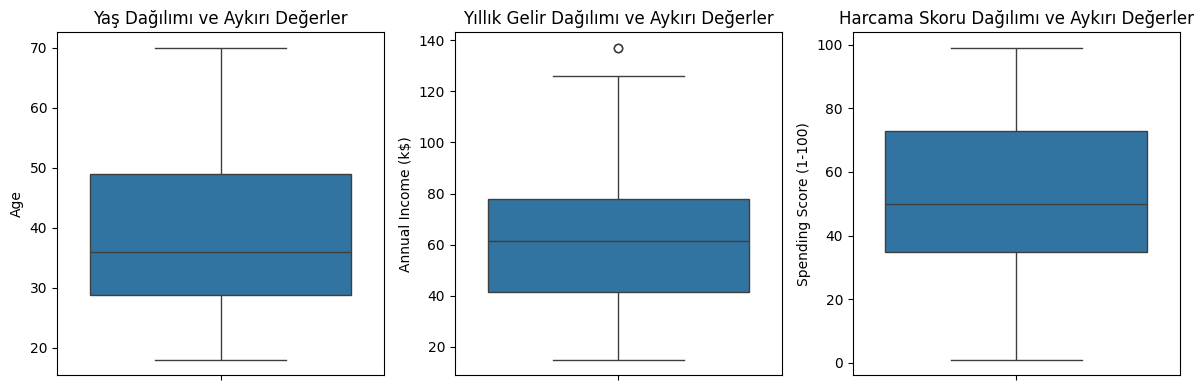

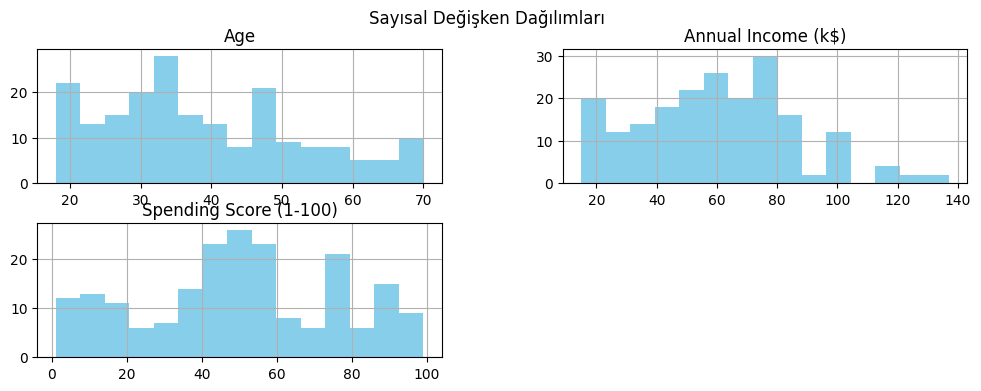

In [6]:
# 📊 Dağılım ve Aykırı Değer Kontrolü

import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot: Aykırı değerleri kontrol etmek için
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.boxplot(y=df_clean['Age'])
plt.title('Yaş Dağılımı ve Aykırı Değerler')

plt.subplot(1,3,2)
sns.boxplot(y=df_clean['Annual Income (k$)'])
plt.title('Yıllık Gelir Dağılımı ve Aykırı Değerler')

plt.subplot(1,3,3)
sns.boxplot(y=df_clean['Spending Score (1-100)'])
plt.title('Harcama Skoru Dağılımı ve Aykırı Değerler')

plt.tight_layout()
plt.show()

# Histogram: Dağılımları görselleştirme
df_clean[['Age','Annual Income (k$)','Spending Score (1-100)']].hist(figsize=(12,4), bins=15, color='skyblue')
plt.suptitle('Sayısal Değişken Dağılımları')
plt.show()

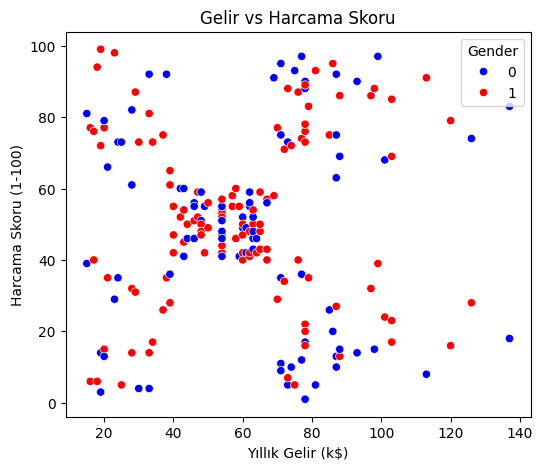

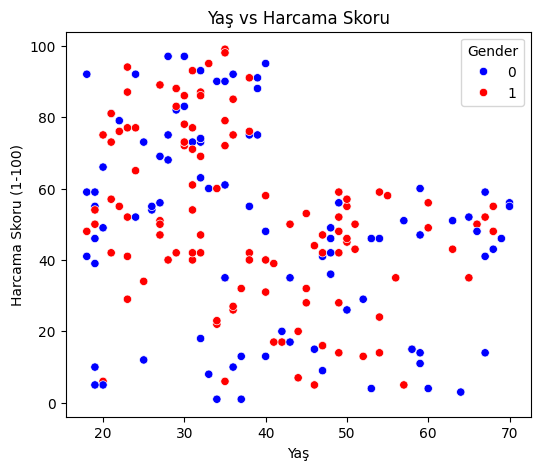

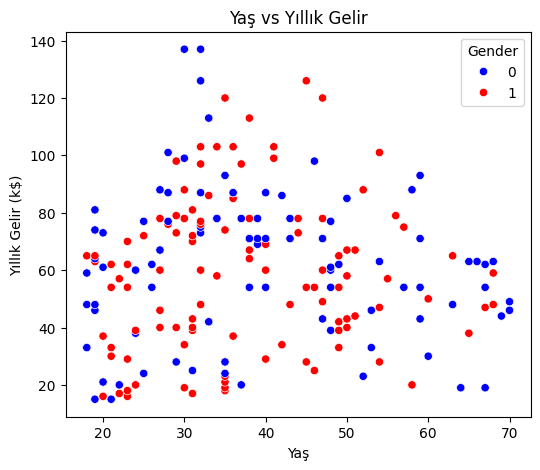

In [7]:
#3️⃣ Scatter Plot – Değişkenler Arası İlişkiler

plt.figure(figsize=(6,5))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Gender', data=df_clean, palette=['blue','red'])
plt.title('Gelir vs Harcama Skoru')
plt.xlabel('Yıllık Gelir (k$)')
plt.ylabel('Harcama Skoru (1-100)')
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x='Age', y='Spending Score (1-100)', hue='Gender', data=df_clean, palette=['blue','red'])
plt.title('Yaş vs Harcama Skoru')
plt.xlabel('Yaş')
plt.ylabel('Harcama Skoru (1-100)')
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x='Age', y='Annual Income (k$)', hue='Gender', data=df_clean, palette=['blue','red'])
plt.title('Yaş vs Yıllık Gelir')
plt.xlabel('Yaş')
plt.ylabel('Yıllık Gelir (k$)')
plt.show()


## 🔍 Optimal Küme Sayısı – Elbow Method

Bu yöntemde, farklı küme sayıları için toplam hata (inertia) hesaplanır.
Dirsek noktasının oluştuğu değer, ideal küme sayısını gösterir.

## 📊 Veri Görselleştirme Analizi
Histogram grafiklerinde müşterilerin büyük bir kısmının orta yaş
aralığında toplandığı görülmektedir. Yıllık gelir ve harcama skoru
dağılımları, düşük, orta ve yüksek seviyelerde müşteri gruplarının
bulunduğunu göstermektedir.

Yıllık gelir ile harcama skoru arasındaki saçılım grafiği incelendiğinde,
müşterilerin benzer davranışlar etrafında kümelenme eğiliminde olduğu
gözlemlenmiştir.

📌 Sonuç: Görselleştirme çıktıları, müşteri davranışlarının
K-Means kümeleme algoritması ile ayrıştırılabileceğini göstermektedir.

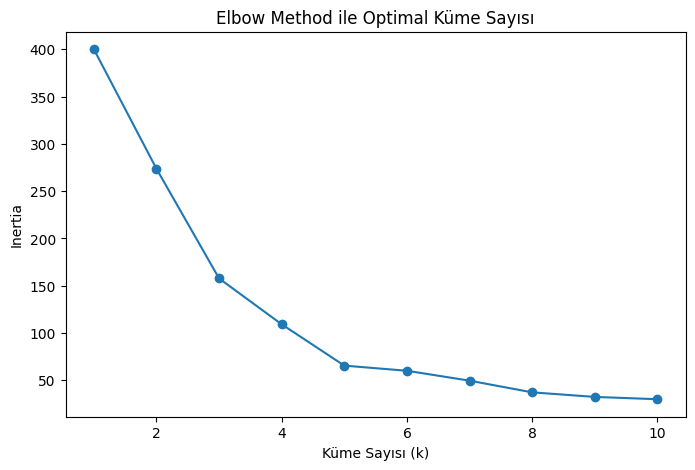

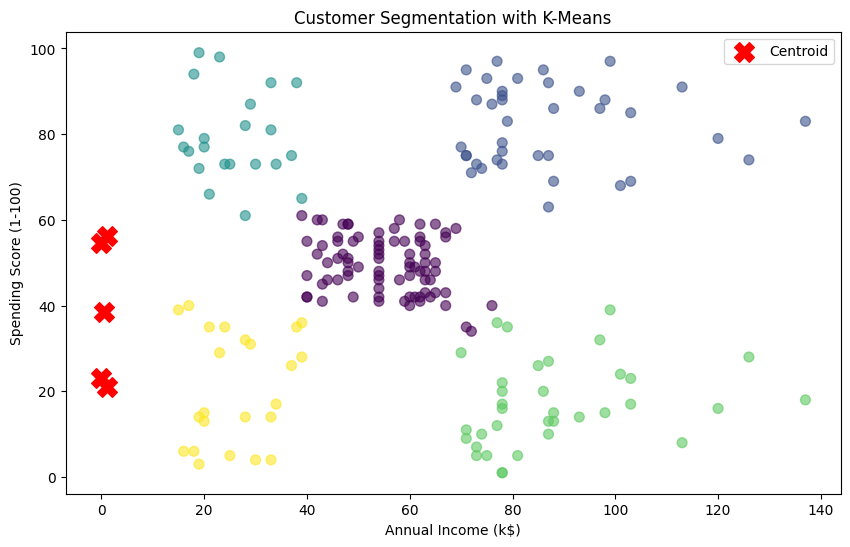

In [8]:
# 📌 4️⃣ K-Means Kümeleme ve Scatter Plot

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Kümeleme için kullanılacak özellikler (ölçeklenmiş)
X = scaled_data[:, [
    df_model.columns.get_loc('Annual Income (k$)'),
    df_model.columns.get_loc('Spending Score (1-100)')
]]

inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method ile Optimal Küme Sayısı')
plt.show()


# Kümelerin sayısı (önceden scatter plot gözlemi ile 5 belirledik)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

# Küme etiketlerini DataFrame'e ekle
df['Cluster'] = clusters

# Kümelerin merkezlerini al
# 🔹 Scaled uzaydaki centroidler
centroids_scaled = kmeans.cluster_centers_

# 🔹 Centroidleri orijinal ölçeğe geri çevir
centroids_original = scaler.inverse_transform(
    np.c_[
        centroids_scaled[:, 0], 
        centroids_scaled[:, 1],
        np.zeros(len(centroids_scaled)),
        np.zeros(len(centroids_scaled))
    ]
)[:, :2]

# 🎨 Scatter Plot
plt.figure(figsize=(10,6))
plt.scatter(
    df['Annual Income (k$)'], 
    df['Spending Score (1-100)'],
    c=df['Cluster'],
    cmap='viridis',
    s=50,
    alpha=0.6
)

# Centroidleri ekle
plt.scatter(centroids_original[:,0], centroids_original[:,1], c='red', s=200, marker='X', label='Centroid')

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Customer Segmentation with K-Means')
plt.legend()
plt.show()


📌 Not: K-Means algoritması ölçeklenmiş veriler üzerinde çalıştırılmıştır.
Ancak görselleştirmelerde, segmentlerin iş birimleri tarafından
daha kolay yorumlanabilmesi için orijinal değişken değerleri kullanılmıştır.

<details>
<summary><strong>📊 K-Means Müşteri Segmentasyonu Scatter Plot Analizi</strong></summary>

**Grafik Özeti:**

Bu scatter plot, müşterilerin **Yıllık Gelir (k$)** ve **Harcama Skoru (1-100)** arasındaki ilişkiyi göstermektedir. Her nokta bir müşteriyi temsil ediyor ve farklı renkler K-Means ile belirlenen **5 ana segmenti** gösteriyor. Kırmızı çarpı işaretleri ise kümelerin merkezlerini (centroid) gösteriyor.

---

### 1️⃣ Segment Analizi

1. **Standart Müşteriler (Orta Grup)**
   * Konum: Yıllık Gelir 40-65k$, Harcama Skoru 40-60
   * Yoğunluk: En kalabalık küme
   * Özellik: Ortalama gelir ve harcama; stabil müşteri kitlesi

2. **VIP / Hedef Kitle (Sağ Üst)**
   * Konum: Yıllık Gelir 80-140k$, Harcama Skoru 60-100
   * Özellik: En değerli müşteriler; yüksek gelir ve yüksek harcama
   * Strateji: Özel kampanyalar ve sadakat programları

3. **Tutumlu Yüksek Gelirliler (Sağ Alt)**
   * Konum: Yüksek gelir, düşük harcama (0-40)
   * Özellik: Parası var ama harcama yapmıyor
   * Strateji: Lüks ürün veya özel indirimlerle harcamayı artırmak

4. **Dikkatsiz / Harcamayı Sevenler (Sol Üst)**
   * Konum: Düşük gelir, yüksek harcama
   * Özellik: Genç veya sadık, harcama yoğun
   * Strateji: Sadakat ve yönlendirme kampanyaları

5. **Düşük Potansiyel (Sol Alt)**
   * Konum: Düşük gelir, düşük harcama
   * Özellik: Öncelikli hedef değil
   * Strateji: Standart promosyonlarla yeterli

---

### 2️⃣ Cinsiyet Dağılımı
* Noktalar: Mavi (0), Kırmızı (1)
* Yorum: Gelir ve harcama davranışları cinsiyetten bağımsız; her segmentte homojen dağılım

---

### 3️⃣ Stratejik Çıkarımlar
* **VIP grubu** odaklı kampanyalar
* **Tutumlu zenginler** için harcama artırıcı teşvikler
* **Orta grup** memnuniyetinin sürekliliği kritik
* **Genç harcamacılar** için yönlendirilmiş kampanyalar

💡 Bu scatter plot, doğal müşteri kümelerini görmemizi ve **K-Means segmentasyonunun stratejik kararlar için kullanılabileceğini** gösteriyor.

</details>


## Segment Profilleri – Özet Tablo
Aşağıdaki tabloda, K-Means algoritması ile elde edilen müşteri segmentlerinin temel demografik ve davranışsal özellikleri özetlenmiştir.

In [9]:
# Segment profilleri tablosu oluşturma

segment_profile = df.groupby('Cluster').agg(
    Customer_Count=('Cluster', 'count'),
    Avg_Age=('Age', 'mean'),
    Avg_Annual_Income=('Annual Income (k$)', 'mean'),
    Avg_Spending_Score=('Spending Score (1-100)', 'mean')
).reset_index()

# Segment isimlerini ekleyelim
segment_profile['Segment_Name'] = segment_profile['Cluster'].map({
    0: "Standart",
    1: "VIP",
    2: "Düşük Gelir – Yüksek Harcama",
    3: "Tutumlu Yüksek Gelir",
    4: "Düşük Potansiyel"
})

# Daha okunaklı hale getirelim
segment_profile = segment_profile[[
    'Segment_Name',
    'Customer_Count',
    'Avg_Age',
    'Avg_Annual_Income',
    'Avg_Spending_Score'
]]

# Ondalıkları yuvarlayalım
segment_profile[['Avg_Age', 'Avg_Annual_Income', 'Avg_Spending_Score']] = \
segment_profile[['Avg_Age', 'Avg_Annual_Income', 'Avg_Spending_Score']].round(2)

segment_profile


,Segment_Name,Customer_Count,Avg_Age,Avg_Annual_Income,Avg_Spending_Score
0,Standart,81,42.72,55.30,49.52
1,VIP,39,32.69,86.54,82.13
2,Düşük Gelir – Yüksek Harcama,22,25.27,25.73,79.36
3,Tutumlu Yüksek Gelir,35,41.11,88.20,17.11
4,Düşük Potansiyel,23,45.22,26.30,20.91


<details>
<summary><strong>Segment Bazlı Müşteri Analizi</strong></summary>

<details>
<summary>🟦 Segment 0 – Standart Müşterileri</summary>
Müşteri Sayısı: 81 (en büyük grup)
Profil: Orta yaş, orta gelir, orta harcama
Yorum: İşletmenin kemik müşteri kitlesini oluşturur.
Strateji: Memnuniyetin korunması, fiyat–performans odaklı kampanyalar
</details>

<details>
<summary>🟨 Segment 1 – VIP Müşteriler</summary>
Profil: Genç–orta yaş, yüksek gelir, yüksek harcama
Yorum: En kârlı ve stratejik müşteri grubu.
Strateji: Özel sadakat programları
Kişiselleştirilmiş teklifler
Premium ürün ve hizmetler
</details>

<details>
<summary>🟥 Segment 2 – Düşük Gelir – Yüksek Harcama</summary>
Profil: Genç, düşük gelirli ama harcama eğilimi yüksek
Yorum: Duygusal veya impulsif tüketim davranışı gösterir.
Risk: Finansal sürdürülebilirlik düşük olabilir.
Strateji:Limitli kampanyalar
Sadakat yerine yönlendirme odaklı pazarlama
</details>

<details>
<summary>🟩 Segment 3 – Tutumlu Yüksek Gelir</summary>

Profil: Yüksek gelirli ancak harcama skoru düşük
Yorum: Potansiyeli yüksek ama ikna edilmesi zor.
Strateji: Değer algısı oluşturan kampanyalar
Kalite, prestij ve güven vurgusu
</details>

<details>
<summary>⬛ Segment 4 – Düşük Potansiyel</summary>
Profil: Yaş ortalaması yüksek, düşük gelir ve düşük harcama
Yorum: Kârlılık açısından öncelikli hedef değil.
Strateji: Genel promosyonlar
Minimum pazarlama maliyeti
</details>
    
</details>

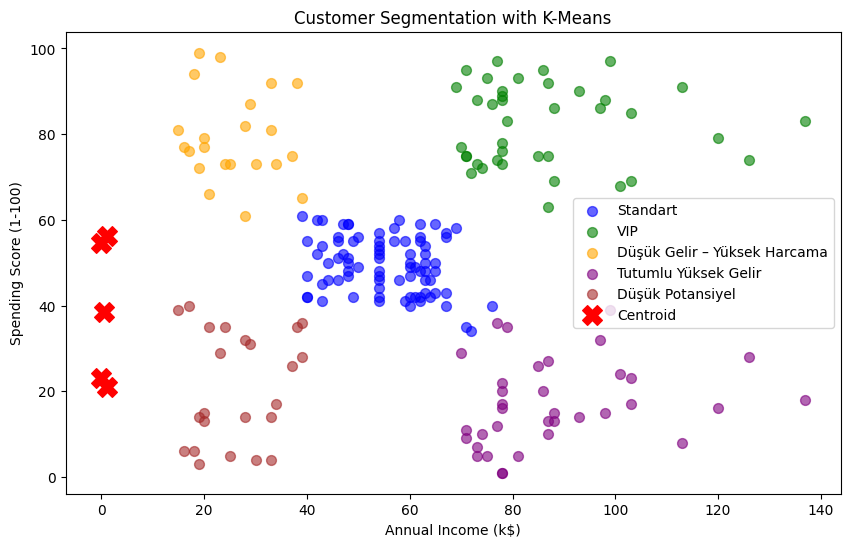

In [10]:
import matplotlib.pyplot as plt

# Segment isimlerini tanımlıyoruz
segment_names = {
    0: "Standart",
    1: "VIP",
    2: "Düşük Gelir – Yüksek Harcama",
    3: "Tutumlu Yüksek Gelir",
    4: "Düşük Potansiyel"
}

# Her cluster için renkler
colors = ['blue', 'green', 'orange', 'purple', 'brown']

plt.figure(figsize=(10,6))

# Her cluster'ı ayrı ayrı çiziyoruz
for cluster_id in range(5):
    cluster_data = df[df['Cluster'] == cluster_id]
    plt.scatter(
        cluster_data['Annual Income (k$)'], 
        cluster_data['Spending Score (1-100)'], 
        s=50, alpha=0.6, 
        c=colors[cluster_id], 
        label=segment_names[cluster_id]
    )

# Centroidleri ekle
plt.scatter(
    centroids_original[:, 0],
    centroids_original[:, 1],
    c='red', s=200, marker='X', label='Centroid'
)

plt.title('Customer Segmentation with K-Means')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

## 🔍 Optimal Küme Sayısı – Elbow Method

Bu yöntemde, farklı küme sayıları için toplam hata (inertia) hesaplanır.
Dirsek noktasının oluştuğu değer, ideal küme sayısını gösterir.

<details>
<summary><strong>📊 Her Segmenti Farklı Renk ve İsimlerle Görselleştirme</strong></summary>
1. **Segmentler net ayrılmış**:

   * Mavi: Standart
   * Yeşil: VIP
   * Sarı: Tutumlu Yüksek Gelir
   * Mor: Dikkatsiz / Harcamayı Seven
   * Kahverengi: Düşük Potansiyel

2. **Centroidler doğru konumda**: Kırmızı X’ler kümelerin merkezlerini gösteriyor ve segmentlerin genel konumlarını özetliyor.

3. **Segment isimleri ve renkler okunaklı**: Legend ile segmentler kolayca ayırt edilebiliyor.

4. **Geliştirme fırsatı**:

   * Hover ile müşteri sayısını veya örnek müşteri bilgilerini göstermek için **Plotly** ile interaktif versiyon oluşturabiliriz.
   * Yaş, cinsiyet gibi ek değişkenleri renk veya boyut ile göstermek grafiği daha zengin yapar.
</details>

## 🔍 Optimal Küme Sayısı – Silhouette Score

Silhouette Score, bir veri noktasının kendi kümesine ne kadar iyi
uyduğunu ölçer. Skor -1 ile 1 arasındadır, yüksek değer daha iyidir.


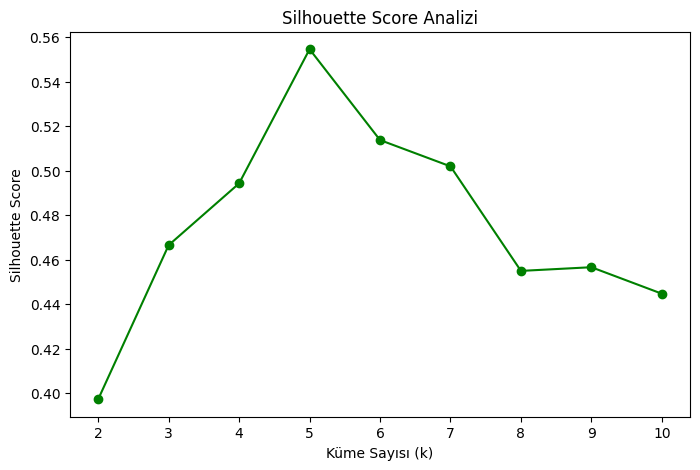

In [11]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Analizi')
plt.show()

📊 **Yorum:**

Elbow Method grafiğinde kırılmanın k=5 civarında olduğu gözlemlenmiştir.
Silhouette Score değerleri de k=5 için göreceli olarak yüksek bir skor sunmaktadır.

Bu nedenle, müşteri segmentasyonu için **5 küme** optimal olarak seçilmiştir.